# Minimal example - Pytorch API

## Define nn.Module with feature extractor network

Notes:
* In the forward funcition one must define the `self.feature_map = some_tensor` parameter. This parameter is used by the `PytorchReceptiveField` to get the desired feature map. The feature map tensor is of shape [batch_size, num_channels, width, height]

In [1]:
import torch
import torch.nn as nn

# This VGG network is inspired by the 
class SimpleVGG(nn.Module):
    def __init__(self, fm_mode: bool = False):
        super(SimpleVGG, self).__init__()
        _layers_cfg = [32, 'M', 64, 'M', 96, 96, 'M', 128, 128]        
        self.features = self._make_layers(_layers_cfg, fm_mode)

    def forward(self, x):
        out = self.features(x)
        # this is required for pytorch, a paramter with this name is 
        # used as a final feature map
        self.feature_map = out
        return out

    def _make_layers(self, cfg, fm_mode):
        layers = []
        pool_layer = nn.AvgPool2d if fm_mode else nn.MaxPool2d
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [pool_layer(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), nn.BatchNorm2d(x)]
                
                if not fm_mode:
                    layers += [nn.ReLU(inplace=True)]
                in_channels = x
        
        return nn.Sequential(*layers)    

## Define model build function
Notes:
* In case when using layers which depends behave differently on training and eval mode it is recommended to set model to eval mode: `model.eval()`

In [2]:
def model_fn() -> nn.Module:
    model = SimpleVGG(fm_mode=True)
    model.eval()
    return model

## Run RF estimation

In [6]:
from receptivefield.pytorch import PytorchReceptiveField

input_shape = [128, 128, 3]

rf = PytorchReceptiveField(model_fn)
rf_params = rf.compute(input_shape = input_shape)
rf_params

[2018-07-16 09:24:32,596][ INFO][pytorch.py]::Feature map shape: GridShape(n=1, w=16, h=16, c=128)
[2018-07-16 09:24:32,598][ INFO][pytorch.py]::Input shape      : GridShape(n=1, w=128, h=128, c=3)
[2018-07-16 09:24:32,607][ INFO][base.py]::Computing receptive field at center (8, 8) with offset GridPoint(x=0, y=0)
[2018-07-16 09:24:32,668][ INFO][base.py]::Computing receptive field at center (8, 8) with offset GridPoint(x=1, y=1)
[2018-07-16 09:24:32,772][ INFO][base.py]::Estimated RF params: ReceptiveFieldDescription(offset=(4.0, 4.0), stride=(8.0, 8.0), size=Size(w=62, h=62))


ReceptiveFieldDescription(offset=(4.0, 4.0), stride=(8.0, 8.0), size=Size(w=62, h=62))

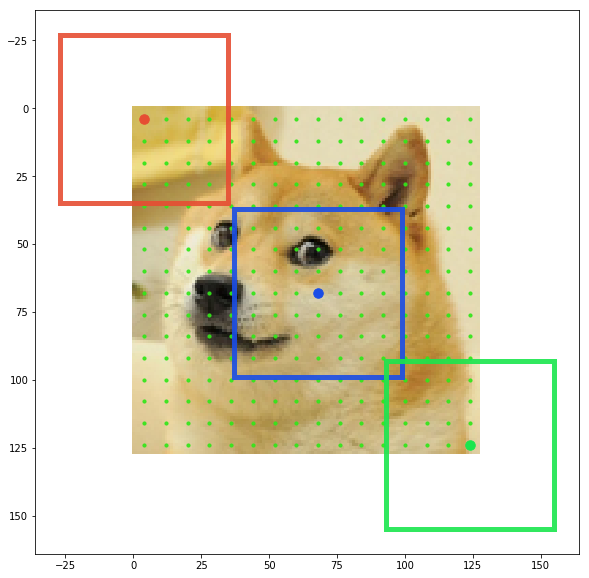

In [7]:
from receptivefield.image import get_default_image
rf.plot_rf_grid(get_default_image(input_shape, name='doge'))

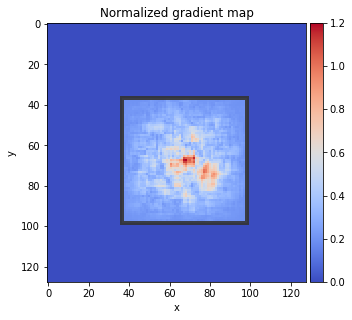

In [8]:
rf.plot_gradient_at((8, 8))